In [ ]:
#安装所需依赖
#!pip install -r requirements.txt
#嵌入模型下载链接：https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz
#下载后解压

Transformer结构图

<img src="transformer结构.png" alt="结构图" width="400" height="200">


根据结构，可以将整个transformer分成以下部分：
- 输入
    - 词嵌入
    - 位置编码
- Encoder
    - 多头自注意力机制
    - 残差连接与层归一化
    - FFN
- Decoder
    - 掩码自注意力机制
    - 交叉注意力机制
    - 其余与Encoder相同

## 1.词嵌入与位置编码
- 调用FastText嵌入模型
- 将句子转为tokens,转成向量
- 编写位置编码函数

In [1]:
from gensim.models import KeyedVectors

# 加载 .vec 文件（注意 binary=False ）
#.vec文件是文本格式，可直接查看。 但由于数据量大，解析速度会很慢，需等待比较长时间（在我的电脑上是3分半左右）
embedded_model = KeyedVectors.load_word2vec_format("cc.zh.300.vec", binary=False)


In [2]:
#.vec文件第一行是词汇表大小和模型维度
def get_vocab_size(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        first_line = f.readline().strip()
        print(f"第一行内容：{first_line}")
        parts = first_line.split()
        if len(parts) == 2:
            vocab_size, vector_dim = map(int, parts)
            print(f"词汇表大小: {vocab_size}")
            print(f"词向量维度: {vector_dim}")
        else:
            print("该文件可能没有头部信息，需要手动统计。")
        return vocab_size, vector_dim


vocab_size, d_model = get_vocab_size('cc.zh.300.vec')


第一行内容：2000000 300
词汇表大小: 2000000
词向量维度: 300


In [3]:
#1.1 模型测试与基本操作

#查询词向量
word_vector = embedded_model["春风"]
print(f"word vector shape: {word_vector.shape}")

#找出于指定词最相似的5个词
print(f"最接近的词:{embedded_model.most_similar('国王', topn=5)}")

#计算两个词的余弦相似度
similarity = embedded_model.similarity('男人', '女人')
print(f"相似度:{similarity}")

#类比推理  国王 + 女人 - 男人
result = embedded_model.most_similar(positive=['国王', '女人'], negative=['男人'],topn=5)
result


word vector shape: (300,)
最接近的词:[('國王', 0.6510177254676819), ('泰瑞纳斯', 0.6426193118095398), ('王后们', 0.6408271193504333), ('君主', 0.6258307099342346), ('王宫', 0.6208195090293884)]
相似度:0.8857553601264954


[('王后们', 0.6541499495506287),
 ('王宫', 0.5844751000404358),
 ('王后', 0.5730476975440979),
 ('泰瑞纳斯', 0.5533304214477539),
 ('國王', 0.5503569841384888)]

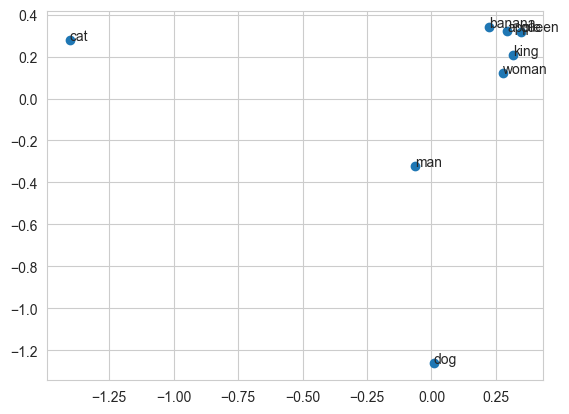

In [4]:
#可视化词向量  将词向量降维到2维
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = ['king', 'queen', 'man', 'woman','dog','cat','apple','banana']
vectors = [embedded_model[word] for word in words]

pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()


In [5]:
#1.2 分词，转成词向量
import jieba
from gensim.models import KeyedVectors

def sentence_to_vectors_verbose(sentence, model):
    #jieba分词
    tokens = list(jieba.cut(sentence))
    vectors = []
    tokens_info = []

    #将分词结果嵌入成向量
    for token in tokens:
        token_vectors, token_labels = get_token_vector_recursive_verbose(token, model)
        vectors.extend(token_vectors)
        tokens_info.extend(token_labels)

    return vectors, tokens_info

def get_token_vector_recursive_verbose(token, model):
    """
    递归获取token向量，同时记录是直接命中还是细分。
    """
    if token in model:
        return [model[token]], [{'token': token, 'source': 'direct'}]
    elif len(token) == 1:
        return [], [{'token': token, 'source': 'OOV'}]  # 可以选择用UNK
    else:
        sub_vectors = []
        sub_info = []
        for char in token:
            if char in model:
                sub_vectors.append(model[char])
                sub_info.append({'token': char, 'source': 'split'})
            else:
                sub_info.append({'token': char, 'source': 'OOV'})
        return sub_vectors, sub_info


# 测试句子
sentence = "今天天气不错"
sentence_vectors, tokens_info = sentence_to_vectors_verbose(sentence, embedded_model)

# 展示分词与来源
print("分词与处理信息：")
for info in tokens_info:
    print(f"{info['token']} - {info['source']}")

print(f"\n总向量数: {len(sentence_vectors)}")
print(f"每个向量维度: {sentence_vectors[0].size if sentence_vectors else '无向量'}")


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\jingl\AppData\Local\Temp\jieba.cache
Loading model cost 0.399 seconds.
Prefix dict has been built successfully.


分词与处理信息：
今 - split
天 - split
天 - split
气 - split
不错 - direct

总向量数: 5
每个向量维度: 300


In [6]:
#1.3 位置编码
import numpy as np

#输入为句子长度与向量维度
def positional_encoding(seq_len, dim):
    pos_enc = np.zeros((seq_len, dim))
    for pos in range(seq_len):
        for i in range(0, dim, 2):
            pos_enc[pos, i] = np.sin(pos / (10000 ** ((2 * i) / dim)))
            if i + 1 < dim:
                pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((2 * i) / dim)))
    return pos_enc  # shape: (seq_len, dim)

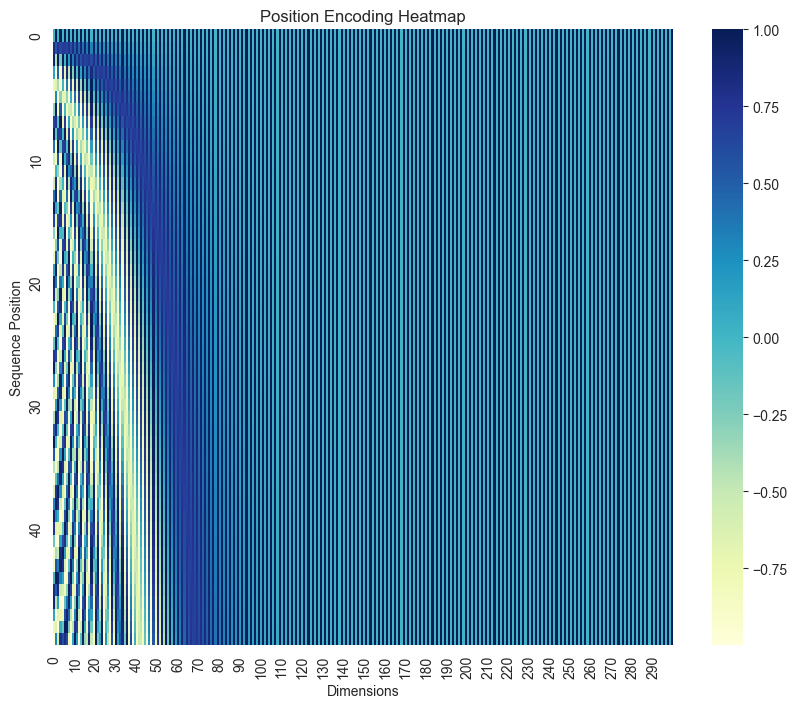

In [7]:
#可视化位置编码结果——使用热力图，低维捕捉高频信息颜色变化剧烈，反之高维颜色变化缓慢
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_vectors(vectors):
    # 绘制热力图
    plt.figure(figsize=(10, 8))
    sns.heatmap(vectors, cmap='YlGnBu', cbar=True, xticklabels=10, yticklabels=10)
    plt.title("Position Encoding Heatmap")
    plt.xlabel("Dimensions")
    plt.ylabel("Sequence Position")
    plt.show()

# 测试,生成50个句子，维度300
plot_vectors(positional_encoding(50,300))

In [8]:
#原句子向量加上位置编码
embedded_vectors = sentence_vectors + positional_encoding(len(sentence_vectors), sentence_vectors[0].size)
print(embedded_vectors.shape)

#将输入格式转成(batch_size,sentence_len,dim),且转成torch下的tensor
import torch
embed_tensor = torch.tensor(embedded_vectors)
embed_tensor = embed_tensor.unsqueeze(0).float()  #这里输入只有一句，直接将batch_size设为1
print(embed_tensor.shape)

(5, 300)
torch.Size([1, 5, 300])


## 2.多头注意力机制
- 生成Q,K,V矩阵，拆分多头
- 计算注意力得分

注意力计算方式： $$ Attention = Softmax(\frac{Q*K^T}{\sqrt{dK}}) *V$$

In [9]:
#2.1 多头自注意力机制
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadSelfAttention(nn.Module):
    def __init__(self,d_model,n_head,dropout=0.1):
        super().__init__()
        assert d_model % n_head == 0,"d_model 必须能被n_head整除"

        self.d_model = d_model
        self.n_head = n_head       #注意力头数
        self.head_dim = d_model // n_head
        self.dropout = nn.Dropout(dropout)

        #qkv：输入的线性映射 o：输出
        self.q = nn.Linear(d_model,d_model)
        self.k = nn.Linear(d_model,d_model)
        self.v = nn.Linear(d_model,d_model)
        self.o = nn.Linear(d_model,d_model)


    def forward(self, x):
        batch_size ,seq_len ,d_model = x.size()
        # print(f"batch_size:{batch_size},seq_len:{seq_len},d_model:{d_model}")

        #拆分为多头 x.shape = (batch_size,seq_len,n_head,d_model),这里先将d_model拆分成n_head*head_dim,为了方便计算，再将seq_len和n_head的位置交换
        #最终格式是(batch_size,n_head,seq_len,head_dim)
        Q = self.q(x).view(batch_size,seq_len,self.n_head,self.head_dim).transpose(1, 2)
        K = self.k(x).view(batch_size,seq_len,self.n_head,self.head_dim).transpose(1, 2)
        V = self.v(x).view(batch_size,seq_len,self.n_head,self.head_dim).transpose(1, 2)

        #计算注意力
        attention_scores = torch.matmul(Q, K.transpose(-2, -1))
        attention_scores = attention_scores / math.sqrt(self.head_dim)
        attention_scores = F.softmax(attention_scores, dim=-1)
        attention_scores = F.dropout(attention_scores)  #dropout,参考《Attention is all you need》原文，防止注意力过拟合
        attention_output = torch.matmul(attention_scores, V)

        #合并 与拆分同理，要注意在.view和.transpose后张量变为内存不连续（.view会改变索引方式），所以需要.contiguous进行连续化
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size,seq_len, self.d_model)

        output = self.o(attention_output)
        return output

In [10]:
multi_attention = MultiHeadSelfAttention(d_model=embed_tensor.shape[2],n_head=5)
atten_output = multi_attention(embed_tensor)
print(atten_output.shape)

torch.Size([1, 5, 300])


## 3.残差连接与层归一化
- 层归一化原理
- Pytorch残差连接与层归一化

层归一化原理:
- 假设输入是一个向量：$$ x = [x_1,x_2,...,x_H]$$ $$ μ = \frac{1}{H} \sum_{i=1}^{H} x_i $$ $$σ = \sqrt{\frac{1}{H} \sum_{i=1}^{H}(x_i - μ)^2 + ϵ} $$
- 归一化后： $$\hat x_i = \frac{x_i - μ}{σ}$$
- 再进行缩放平移：$$ y_i =  γ \hat x_i + β$$
- 其中：𝛾,𝛽 是可学习参数。ϵ 是一个防止除 0 的小值

In [11]:
def layer_norm_manual(x, eps=1e-5):
    mean = x.mean(dim=-1, keepdim=True)
    std = x.std(dim=-1, keepdim=True)
    return (x - mean) / (std + eps)

# 示例
x = torch.randn(32, 10, 512)
output = layer_norm_manual(x)
print(output.shape)


torch.Size([32, 10, 512])


In [12]:
#实践中主要调用pytorch封装的函数
import torch
import torch.nn as nn

# 假设输入 (batch_size, seq_len, hidden_size)
x = torch.randn(32, 10, 512)

# 创建LayerNorm（对最后一维做归一化）
layer_norm = nn.LayerNorm(normalized_shape=512)

# 使用
output = layer_norm(x)
print(output.shape)  # torch.Size([32, 10, 512])


torch.Size([32, 10, 512])


In [13]:
#残差连接则是将上一层输出连接到当前层输出（直接相加）
class ResidualLayerNorm(nn.Module):
    def __init__(self,size,dropout=0.1):
        super(ResidualLayerNorm,self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x,sublayer_output):
        x = self.norm(x + self.dropout(sublayer_output))
        return x

## 4.FFN前馈神经网络
- 结构：$$FFN(x) = ReLu(xW_1 + b1)W_2 + b2 $$
- 其中：$W_1$通常是4倍于输入维度，用来将输入非线性映射到更高维的信息以获得更丰富的语义表达，$W_2$降维回原来维度，ReLu是非线性激活函数


In [14]:
class FFN(nn.Module):
    def __init__(self,d_model,d_ff,dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model,d_ff)  #d_ff：隐藏层维度，通常取4倍d_model
        self.relu = nn.ReLU()
        self.w2 = nn.Linear(d_ff,d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.w2(x)

        return x

## 5.Encoder,各模块封装整合

In [15]:
class Transformer_encoder(nn.Module):
    def __init__(self,d_model,d_ff,n_head,dropout=0.1):
        super().__init__()

        self.attention = MultiHeadSelfAttention(d_model,n_head,dropout=dropout)
        self.ffn = FFN(d_model,d_ff,dropout=dropout)
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        atten_output = self.attention(x)
        x = self.layer_norm_1(x + self.dropout(atten_output))

        ffn_output = self.ffn(x)
        x = self.layer_norm_2(x + self.dropout(ffn_output))

        return x


In [16]:
#结构图中，Encoder需要将上述模块重复N次
#这里使用ModuleList实现
class TransformerEncoderStack(nn.Module):
    def __init__(self, n_layers, d_model, d_ff, n_head, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            Transformer_encoder(d_model, d_ff, n_head, dropout) for _ in range(n_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [17]:
#可视化张量，热力图
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def visualize_tensor_stages(*tensors, labels=None, title='Tensor Evolution Heatmap'):
    """
    可视化多个阶段的 [batch, seq_len, d_model] 张量。

    参数：
    - *tensors: 任意数量的张量，每个形状为 [batch, seq_len, d_model]
    - labels: 每个张量的标签（可选），用于标题显示
    """
    num_tensors = len(tensors)
    if labels is None:
        labels = [f'Stage {i}' for i in range(num_tensors)]

    batch_idx = 0  # 默认只取第一个 batch 可视化

    fig, axes = plt.subplots(1, num_tensors, figsize=(6 * num_tensors, 5))
    if num_tensors == 1:
        axes = [axes]

    for i, tensor in enumerate(tensors):
        assert tensor.dim() == 3, f"Tensor {i} must have shape [batch, seq_len, d_model]"
        data = tensor[batch_idx].detach().cpu().numpy()  # shape: [seq_len, d_model]

        sns.heatmap(data, ax=axes[i], cmap='viridis')
        axes[i].set_xlabel('Dimension (d_model)')
        axes[i].set_ylabel('Token Position (seq_len)')
        axes[i].set_title(labels[i])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#调用案例
# visualize_tensor_stages(embedding_out, attn_out, resnorm_out,
#                         labels=["Embedding", "Attention Output", "Post-ResNorm"])


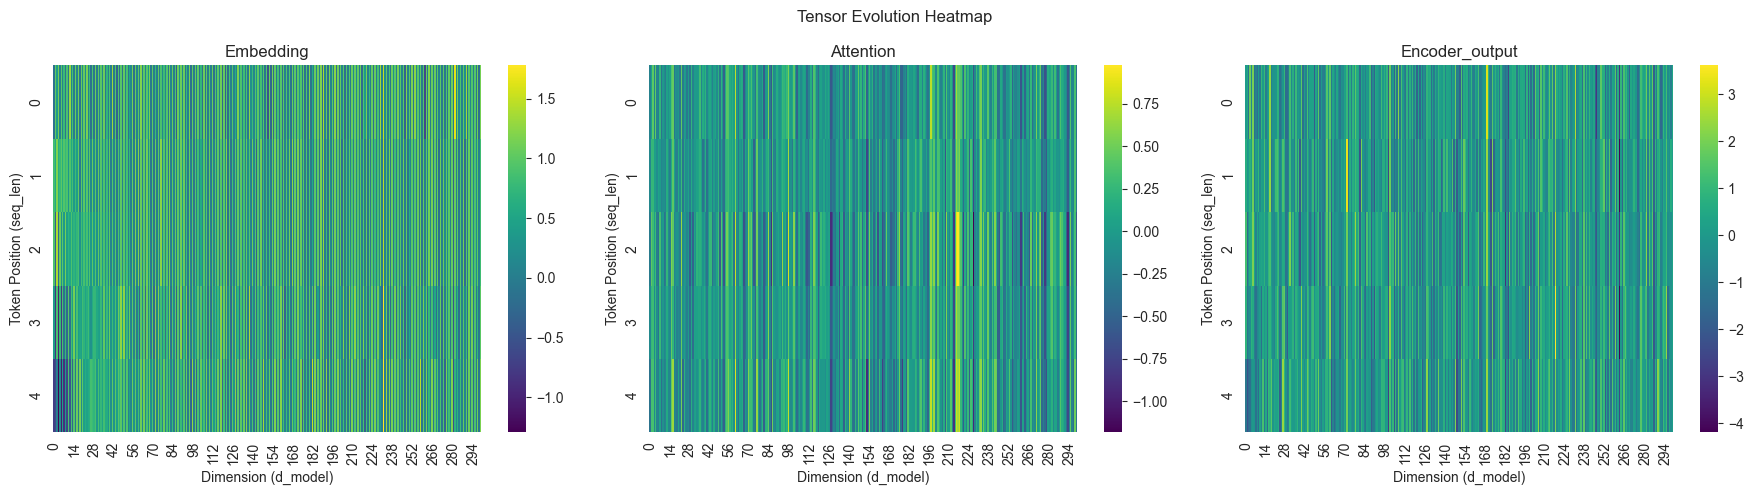

tensor([[[ 0.0507,  0.4300, -1.2200,  ...,  0.1124, -0.8092,  0.3688],
         [ 0.7028, -0.0818,  0.1347,  ..., -0.3485,  0.6204,  0.1768],
         [ 1.2711, -1.4693, -0.2353,  ..., -0.1768, -0.2678,  0.2985],
         [ 0.8938, -1.1439, -0.5843,  ..., -0.5013, -0.1649,  0.2207],
         [-1.0597, -2.2142, -1.5585,  ...,  0.4878, -0.3256,  0.1282]]],
       grad_fn=<NativeLayerNormBackward0>)


In [18]:
encoder = TransformerEncoderStack(n_layers=6, d_model=d_model, d_ff=4*d_model, n_head=5, dropout=0.1)
encoder_output = encoder(embed_tensor)
visualize_tensor_stages(embed_tensor,atten_output,encoder_output
                        ,labels=["Embedding","Attention","Encoder_output"])
print(encoder_output)

## 6.掩码自注意力
- 生成掩码矩阵，掩盖对未来值的询问

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedSelfAttention(nn.Module):
    def __init__(self,d_model,n_head,dropout=0.1,visual=False):
        super().__init__()
        assert d_model % n_head == 0,"d_model 必须能被n_head整除"

        self.d_model = d_model
        self.n_head = n_head
        self.head_dim = d_model // n_head
        self.dropout = nn.Dropout(dropout)
        #可视化开关
        self.visual = visual

        #线性映射
        self.q = nn.Linear(d_model,d_model)
        self.k = nn.Linear(d_model,d_model)
        self.v = nn.Linear(d_model,d_model)
        self.o = nn.Linear(d_model,d_model)


    def forward(self, x):
        batch_size ,seq_len ,d_model = x.size()

        Q = self.q(x).view(batch_size,seq_len,self.n_head,self.head_dim).transpose(1, 2)
        K = self.k(x).view(batch_size,seq_len,self.n_head,self.head_dim).transpose(1, 2)
        V = self.v(x).view(batch_size,seq_len,self.n_head,self.head_dim).transpose(1, 2)

        #计算注意力
        attention_scores = torch.matmul(Q, K.transpose(-2, -1))
        attention_scores = attention_scores / math.sqrt(self.head_dim)
        # 生成掩码矩阵 (下三角矩阵：mask未来信息)
        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).repeat(batch_size, 1, 1)  # (batch_size, seq_len, seq_len)
        mask = (mask == 0)  # 0的部分为mask的区域
        # 应用掩码
        attention_scores = attention_scores.masked_fill(mask == True, -1e9)  # 掩盖上三角
        #可视化掩盖结果
        if self.visual:
            visualize_tensor_stages(attention_scores[-1],title="masking")
            print(attention_scores)
        attention_scores = F.softmax(attention_scores, dim=-1)

        attention_scores = F.dropout(attention_scores)  #dropout
        attention_output = torch.matmul(attention_scores, V)


        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size,seq_len, self.d_model)

        output = self.o(attention_output)
        return output


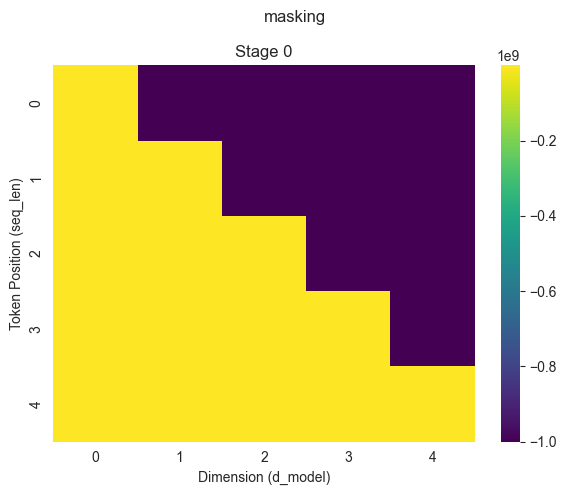

tensor([[[[-3.1921e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-2.7731e-01, -2.9362e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-2.4801e-01, -2.5669e-01, -3.1061e-01, -1.0000e+09, -1.0000e+09],
          [-2.6733e-01, -2.7646e-01, -3.2107e-01, -3.0965e-01, -1.0000e+09],
          [-2.9067e-01, -3.0388e-01, -3.5416e-01, -3.4473e-01, -3.4520e-01]],

         [[-2.6213e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-2.9511e-01, -3.8281e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-3.1615e-01, -4.0878e-01, -4.5013e-01, -1.0000e+09, -1.0000e+09],
          [-2.4633e-01, -3.3669e-01, -3.6246e-01, -3.3676e-01, -1.0000e+09],
          [-2.2290e-01, -3.0997e-01, -3.5385e-01, -3.4292e-01, -2.2863e-01]],

         [[-2.3292e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-1.8972e-01, -1.9403e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09],
          [-1.7056e-01, -1.7473e-01, -1.6601e-01, -1.0000e+09, -1.0000e+

In [20]:
mask_test = MaskedSelfAttention(d_model=d_model,n_head=5,dropout=0.1,visual=True)
mask_test_output = mask_test(embed_tensor)
# print(mask_test_output)

## 7.交叉注意力机制
- 生成当前的查询Q与Encoder输出的K,V

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class CrossAttention(nn.Module):
    def __init__(self, d_model, n_head, dropout=0.1):
        super().__init__()
        assert d_model % n_head == 0, "d_model 必须能被n_head整除"

        self.d_model = d_model
        self.n_head = n_head
        self.head_dim = d_model // n_head
        self.dropout = nn.Dropout(dropout)

        self.q = nn.Linear(d_model, d_model)  # Decoder Query
        self.k = nn.Linear(d_model, d_model)  # Encoder Key
        self.v = nn.Linear(d_model, d_model)  # Encoder Value
        self.o = nn.Linear(d_model, d_model)  # Output

    #输入是前面encoder的输出和decoder前一层的输出
    def forward(self, x_enc, x_dec):
        batch_size, seq_len_dec, d_model = x_dec.size()
        batch_size, seq_len_enc, d_model  = x_enc.size()
        # 生成 decoder的查询矩阵Q
        Q = self.q(x_dec).view(batch_size, seq_len_dec, self.n_head, self.head_dim).transpose(1, 2)
        #生成 encoder的键与值K,V
        K = self.k(x_enc).view(batch_size, seq_len_enc, self.n_head, self.head_dim).transpose(1, 2)
        V = self.v(x_enc).view(batch_size, seq_len_enc, self.n_head, self.head_dim).transpose(1, 2)

        # 计算交叉注意力得分
        attention_scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, n_head, seq_len, seq_len)
        attention_scores = attention_scores / math.sqrt(self.head_dim)
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        # 获取注意力输出
        attention_output = torch.matmul(attention_probs, V)  # (batch_size, n_head, seq_len, head_dim)

        # 合并多头输出
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len_dec, self.d_model)

        # 线性变换得到最终输出
        output = self.o(attention_output)
        return output


In [22]:
#新嵌入
newsentence = "明天天气如何"

new_sen_vector , _ = sentence_to_vectors_verbose(newsentence,embedded_model)

#位置编码
new_embedding = new_sen_vector + positional_encoding(len(new_sen_vector),d_model)
# #转tensor
new_embedding_tensor = torch.tensor(new_embedding)
new_embedding_tensor = new_embedding_tensor.unsqueeze(0).float()      # shape: (1, seq_len, 300)

new_embedding_tensor.shape

torch.Size([1, 3, 300])

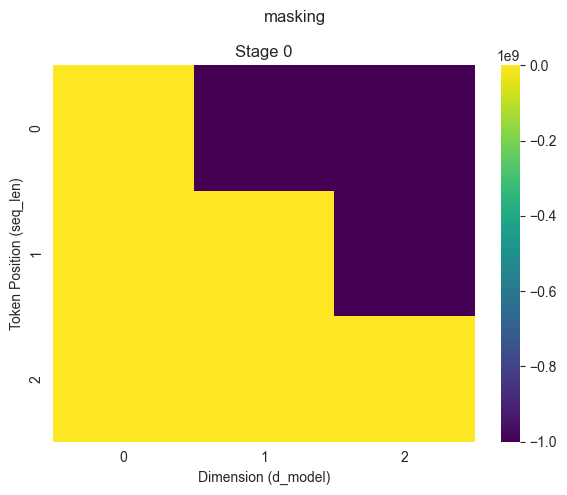

tensor([[[[-5.4082e-02, -1.0000e+09, -1.0000e+09],
          [-1.3302e-01, -1.3630e-01, -1.0000e+09],
          [-2.2650e-01, -2.1747e-01, -2.7045e-01]],

         [[ 1.2900e-01, -1.0000e+09, -1.0000e+09],
          [ 1.0645e-01,  1.6361e-01, -1.0000e+09],
          [ 1.1635e-02,  1.0023e-01,  4.3562e-02]],

         [[-4.3762e-01, -1.0000e+09, -1.0000e+09],
          [-3.9336e-01, -3.5307e-01, -1.0000e+09],
          [-3.5382e-01, -2.9745e-01, -1.9986e-01]],

         [[ 2.5962e-01, -1.0000e+09, -1.0000e+09],
          [ 1.9948e-01,  2.3556e-01, -1.0000e+09],
          [ 2.1782e-01,  2.9386e-01,  2.7036e-01]],

         [[-4.8144e-02, -1.0000e+09, -1.0000e+09],
          [-7.0601e-02, -4.9180e-02, -1.0000e+09],
          [-2.2843e-02,  4.9194e-04, -6.4956e-02]]]],
       grad_fn=<MaskedFillBackward0>)
tensor([[[ 0.6824,  0.0585, -0.2260,  0.3038,  0.3720, -0.3249,  0.3865,
           0.3745,  0.0030, -0.1961, -0.4510,  0.2239, -0.5036, -0.3617,
          -0.0997, -0.6244, -0.0934, -0.

In [23]:
mask_atten = MaskedSelfAttention(new_embedding_tensor.shape[-1],n_head=5,dropout=0.1,visual=True)
cross_atten = CrossAttention(new_embedding_tensor.shape[-1],n_head=5,dropout=0.1)
#
mask_atten_output = mask_atten(new_embedding_tensor)
cross_atten_output = cross_atten(encoder_output, mask_atten_output)
print(cross_atten_output)

## 8.整合Decoder部分

In [24]:
class TransformerDecoder(nn.Module):
    def __init__(self,d_model,d_ff,n_head,dropout=0.1):
        super().__init__()

        self.mask_selfAttention = MaskedSelfAttention(d_model=d_model,n_head=n_head,dropout=dropout)
        self.cross_attention = CrossAttention(d_model=d_model,n_head=n_head,dropout=dropout)
        self.ffn = FFN(d_model,d_ff,dropout=dropout)
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.layer_norm_3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_enc,x):
        mask_attention = self.mask_selfAttention(x)
        x = self.layer_norm_1(x + self.dropout(mask_attention))
        cross_attention = self.cross_attention(x_enc,x)
        x = self.layer_norm_2(x + self.dropout(cross_attention))
        ffn = self.ffn(x)
        x = self.layer_norm_3(x + self.dropout(ffn))

        return x

In [25]:
class TransformerDecoderStack(nn.Module):
    def __init__(self,d_model,d_ff,n_head,n_layer,dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerDecoder(d_model, d_ff, n_head, dropout) for _ in range(n_layer)
        ])

    def forward(self, x_enc,x):
        for layer in self.layers:
            x = layer(x_enc,x)
        return x


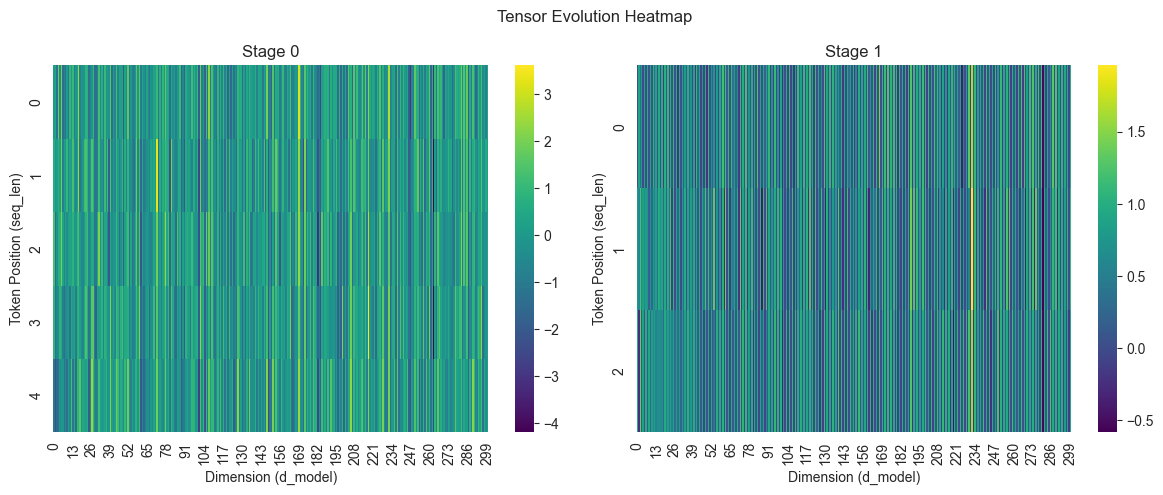

In [26]:
decoder = TransformerDecoderStack(n_layer=6,d_model=d_model,d_ff=4*d_model,n_head=5,dropout=0.1)
decoder_output = decoder(encoder_output,new_embedding_tensor)
visualize_tensor_stages(encoder_output,new_embedding_tensor)


## 9.最终输出
- 输出层（线性映射），大小（词向量维度d_model,词汇表大小vocab_size）
- 推理与训练

In [27]:
class MyTransformer(nn.Module):
    def __init__(self,n_layers,d_model,d_ff,n_head,vocab_size,dropout=0.1):
        super().__init__()
        self.encoder = TransformerEncoderStack(n_layers=n_layers,d_model=d_model,d_ff=d_ff,n_head=n_head,dropout=dropout)
        self.decoder = TransformerDecoderStack(n_layer=n_layers,d_model=d_model,d_ff=d_ff,n_head=n_head,dropout=dropout)
        self.fc_out = nn.Linear(d_model,vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, src,trg):
        enc_output = self.encoder(src)
        dec_output = self.decoder(enc_output,trg)

        output = self.fc_out(dec_output)
        return output



In [28]:
t = MyTransformer(n_layers=6,d_model=d_model,d_ff=4*d_model,n_head=5,dropout=0.1,vocab_size=vocab_size)
prob_out = t(embed_tensor,new_embedding_tensor)
print(prob_out.shape)

torch.Size([1, 3, 2000000])
